In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut

from importlib import reload

import reconstruct as rec

In [18]:
# folder = './__test__/k__2--nens__50--T__10'
# folder = './__test__/k__0--nens__50--T__10'
folder = './__test__/k__5--nens__100--T__10'
rec_dict = ut.json2dict(f'{folder}/reconstructed.json')

In [20]:
reload(rec)

<module 'reconstruct' from '/media/alessandro/OS/Users/ale57/Documents/0. Lyon/WORK/REA-Veros/demo/reconstruct.py'>

In [21]:
rec_dict = rec.reconstruct(f'{folder}/i0020')

DONE


In [22]:
rec_trajs = {}

for rname, r in rec_dict['members'].items():
    traj = []
    for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
        traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
    traj = np.concatenate(traj)

    rec_trajs[rname] = traj

observables = {r: traj[-1,1] for r,traj in rec_trajs.items()}

## Plot trajectories

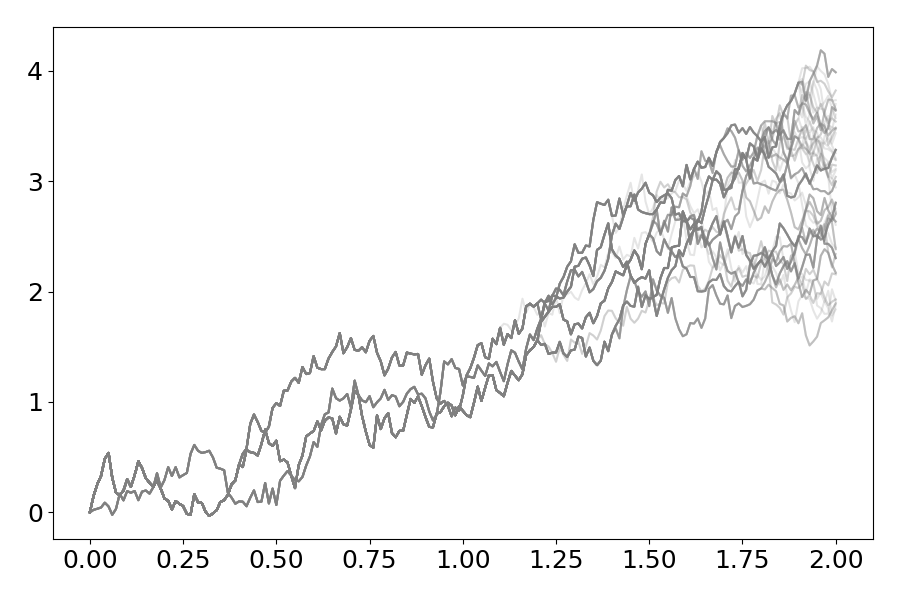

In [23]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

for traj in rec_trajs.values():
    plt.plot(traj[:,0], traj[:,1], color='gray', alpha=0.2)

fig.tight_layout()

## Compute expectations

In [30]:
rec_dict['independent_parents']

[2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 7, 7, 9, 12, 14, 17, 25, 41]

In [33]:
np.mean([r['weight'] for r in rec_dict['members'].values()])

0.002567762445559813

In [25]:
def f(x, a):
    return float(x > a)

def expectation(func, **kwargs):
    _f = np.array([func(x, **kwargs) for x in observables.values()])
    _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)*_n
    std = np.sqrt(np.mean(_f*_w**2))*_n

    return unc.ufloat(mean,std)

In [29]:
expectation(f, a=2)

0.0007669321707346316+/-0.0017081201953651193

In [63]:
r = 'r020'
rec_dict['members'][r]['ancestry']

['e015',
 'e023',
 'e029',
 'e040',
 'e011',
 'e034',
 'e035',
 'e033',
 'e048',
 'e005',
 'e035',
 'e037',
 'e035',
 'e047',
 'e043',
 'e044',
 'e042',
 'e040',
 'e038',
 'e003']

In [65]:
rec_trajs[r][-1,1] - rec_trajs[r][0,1]

2.758845185105002

In [66]:
rec_dict['members'][r]['cum_score']

2.758845185105001

In [67]:
rec_dict['members'][r]['cum_log_escore']/2

2.758845185105001

In [68]:
rec_dict['cum_log_norm_factor']

1.0813225861912483